# Email Spam detection EDA
Prepared By Deepa Francis<br>
For BrainStation<br>
On July 20, 2023

In [1]:
# import relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from scipy.stats import norm

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')

import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords 

# display all columns in dataframe
pd.set_option('display.max_columns', None)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\franc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# loading the data
raw_data = pd.read_csv('raw_data.csv')

In [3]:
# Summary of raw data
print(f"Number of Rows: {raw_data.shape[0]}")
print(f"Number of Columns: {raw_data.shape[1]}")
print(f"Number of missing values: {raw_data.isna().sum().sum()}")
print(f"Number of duplicated rows: {raw_data.duplicated().sum()}")

Number of Rows: 75419
Number of Columns: 5
Number of missing values: 2856
Number of duplicated rows: 1512


In [4]:
# Quickly check the data types
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75419 entries, 0 to 75418
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   label       75419 non-null  int64 
 1   subject     74626 non-null  object
 2   email_to    74843 non-null  object
 3   email_from  75419 non-null  object
 4   message     73932 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.9+ MB


**Missing values**

In [10]:
clean_data = raw_data.copy()
# Check column wise count of missing values
clean_data.isna().sum()

label            0
subject        793
email_to       576
email_from       0
message       1487
dtype: int64

In [11]:
# Calculate the percentage of missing values
percentage_missing = (clean_data.isna().sum() / len(clean_data)) * 100
print(np.round(percentage_missing,2))

label         0.00
subject       1.05
email_to      0.76
email_from    0.00
message       1.97
dtype: float64


In [12]:
# Check column wise count of missing values
clean_data.isna().sum().sum()

2856

In [13]:
# Calculate the percentage of missing values
total_percentage_missing = (clean_data.isna().sum().sum() / len(clean_data)) * 100
print(np.round(total_percentage_missing,2))

3.79


In [14]:
# Delete missing value rows 
clean_data.dropna(inplace = True, axis=0)
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72798 entries, 0 to 75418
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   label       72798 non-null  int64 
 1   subject     72798 non-null  object
 2   email_to    72798 non-null  object
 3   email_from  72798 non-null  object
 4   message     72798 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.3+ MB


**Duplicate Rows**

In [16]:
# Remaining Duplicated rows
clean_data.duplicated().sum()

1354

In [17]:
# Calculate the percentage of duplicate rows
percentage_duplicates = (clean_data.duplicated().sum() / len(clean_data
                                                            )) * 100
print("Percentage of duplicate rows:", np.round(percentage_duplicates,2))

Percentage of duplicate rows: 1.86


We decide to drop duplicate rows because these could be same message content, from same email, sent to same person at different times and we dont have the timestamp to get any additional information from it.

In [18]:
# Drop duplicated rows 
clean_data.drop_duplicates(inplace=True)
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71444 entries, 0 to 75418
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   label       71444 non-null  int64 
 1   subject     71444 non-null  object
 2   email_to    71444 non-null  object
 3   email_from  71444 non-null  object
 4   message     71444 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.3+ MB


In [19]:
clean_data.shape

(71444, 5)

In [20]:
# Summary of clean data
print(f"Number of Rows: {clean_data.shape[0]}")
print(f"Number of Columns: {clean_data.shape[1]}")
print(f"Number of missing values: {clean_data.isna().sum().sum()}")
print(f"Number of duplicated rows: {clean_data.duplicated().sum()}")

Number of Rows: 71444
Number of Columns: 5
Number of missing values: 0
Number of duplicated rows: 0


In [21]:
clean_data.head()

,label,subject,email_to,email_from,message
0,1,"Generic Cialis, branded quality@",the00@speedy.uwaterloo.ca,"""Tomas Jacobs"" <RickyAmes@aol.com>",Content-Type: text/html;\nContent-Transfer-Enc...
1,0,Typo in /debian/README,debian-mirrors@lists.debian.org,Yan Morin <yan.morin@savoirfairelinux.com>,"Hi, i've just updated from the gulus and I che..."
2,1,authentic viagra,<the00@plg.uwaterloo.ca>,"""Sheila Crenshaw"" <7stocknews@tractionmarketin...","Content-Type: text/plain;\n\tcharset=""iso-8859..."
3,1,Nice talking with ya,opt4@speedy.uwaterloo.ca,"""Stormy Dempsey"" <vqucsmdfgvsg@ruraltek.com>","Hey Billy, \n\nit was really fun going out the..."
4,1,or trembling; stomach cramps; trouble in sleep...,ktwarwic@speedy.uwaterloo.ca,"""Christi T. Jernigan"" <dcube@totalink.net>",Content-Type: multipart/alternative;\n ...


In [22]:
X = clean_data.drop(columns='label')
y = clean_data['label']

## Target

In [23]:
label_counts = y.value_counts()
label_counts

1    46768
0    24676
Name: label, dtype: int64

Text(0, 0.5, 'Count')

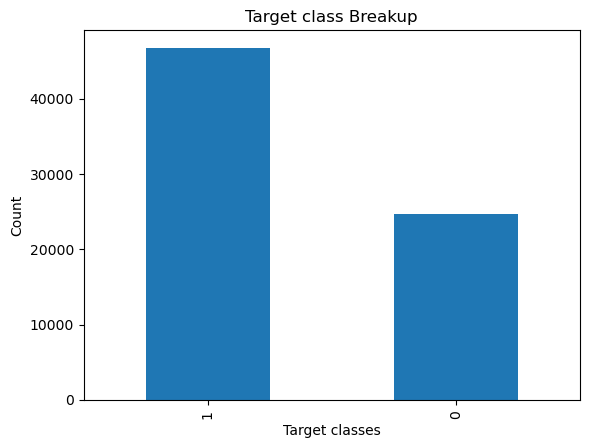

In [24]:
# Plot the unique values of target
label_counts.plot(kind='bar')
plt.title("Target class Breakup")
plt.xlabel("Target classes")
plt.ylabel("Count")

In [25]:
# Percentage value counts of target
label_counts_percentage = y.value_counts(normalize=True) * 100
label_counts_percentage

1    65.46106
0    34.53894
Name: label, dtype: float64

Text(0, 0.5, 'Percentage')

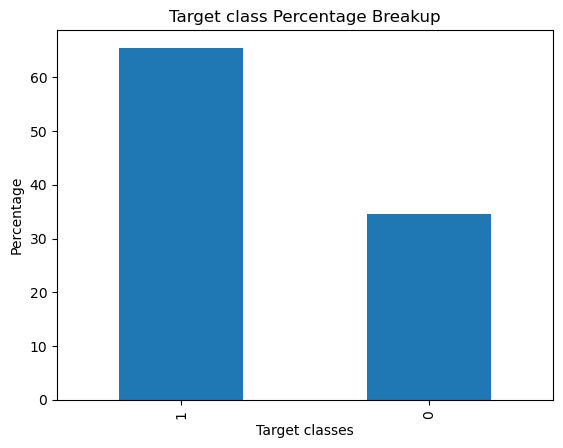

In [26]:
# Plotting the value counts as percentages
label_counts_percentage.plot(kind='bar')
plt.title("Target class Percentage Breakup")
plt.xlabel("Target classes")
plt.ylabel("Percentage")

## Features

In [27]:
X.head()

,subject,email_to,email_from,message
0,"Generic Cialis, branded quality@",the00@speedy.uwaterloo.ca,"""Tomas Jacobs"" <RickyAmes@aol.com>",Content-Type: text/html;\nContent-Transfer-Enc...
1,Typo in /debian/README,debian-mirrors@lists.debian.org,Yan Morin <yan.morin@savoirfairelinux.com>,"Hi, i've just updated from the gulus and I che..."
2,authentic viagra,<the00@plg.uwaterloo.ca>,"""Sheila Crenshaw"" <7stocknews@tractionmarketin...","Content-Type: text/plain;\n\tcharset=""iso-8859..."
3,Nice talking with ya,opt4@speedy.uwaterloo.ca,"""Stormy Dempsey"" <vqucsmdfgvsg@ruraltek.com>","Hey Billy, \n\nit was really fun going out the..."
4,or trembling; stomach cramps; trouble in sleep...,ktwarwic@speedy.uwaterloo.ca,"""Christi T. Jernigan"" <dcube@totalink.net>",Content-Type: multipart/alternative;\n ...


**Balancing and Sampling**

In [28]:
# Number of unique messages
unique_messages = clean_data['message'].value_counts().count()
unique_messages

58291

There are 58291 unique email messages<br>
We can keep just one instance of message. Keeping just one instance of each unique email message can have several advantages:

Reduced Data Redundancy: Redundant data can bias the model, leading to overfitting and poor generalization. By keeping only one instance of each message, you ensure that the dataset is representative of unique email patterns, reducing redundancy and improving model performance.

Efficient Feature Extraction: Redundant information can dominate the feature space, potentially diluting the significance of other relevant features. By eliminating duplicate instances, you maintain a more concise and informative feature space, facilitating more efficient and accurate learning.

In [29]:
# number of unique non-spam messages
unique_nonspam_messages = clean_data[(clean_data['label'] == 0)]['message'].value_counts().count()
# number of unique spam messages
unique_spam_messages = clean_data[(clean_data['label'] == 1)]['message'].value_counts().count()
total_unique_messages = unique_nonspam_messages + unique_spam_messages

# Number of unique messages mapped as both spam and non-spam
duplicate_message_count = total_unique_messages - unique_messages
# Maximum number of data points after taking equal number of unique messages from each target class
max_datapoints = int((unique_nonspam_messages - duplicate_message_count/2)*2)

print(f'Number of unique spam messages: {unique_spam_messages}')
print(f'Number of unique non-spam messages: {unique_nonspam_messages}')
print(f'Number of unique messages mapped as both spam and non-spam: {duplicate_message_count}')
print(f'Maximum number of data points that can be kept after target balancing: {max_datapoints}')

Number of unique spam messages: 33825
Number of unique non-spam messages: 24468
Number of unique messages mapped as both spam and non-spam: 2
Maximum number of data points that can be kept after target balancing: 48934


Next, we are sampling the data to get a balanced target of n unique message instances.
First, we drop the duplicate messages from the filtered data using the drop_duplicates method, considering only the 'message' column. This makes sure that we dont have more than one unique message in our data irrespective of whom it was sent.<br>
We can pick a maximum of 24468 unique values each from both spam and non-spam class to get a balanced target of non duplicated message feature.<br>
Next, we use the sample method to randomly select 1000 rows for each label. Thus we will get a balanced target data.<br>
The resulting DataFrame 'sampled_data' will contain 1000 rows for each label (0 and 1) with unique messages.
It is made sure that the number of unique messages mapped as both spam and non-spam is zero.

In [33]:
# Filter unique messages
filtered_data = clean_data.drop_duplicates(subset='message')

# Randomly sample 1000 rows for label 0
label_0_sample = filtered_data[filtered_data['label'] == 0].sample(n=10000, random_state=42)

# Randomly sample 1000 rows for label 1
label_1_sample = filtered_data[filtered_data['label'] == 1].sample(n=10000, random_state=42)

# Concatenate the sampled data
sampled_data = pd.concat([label_0_sample, label_1_sample], ignore_index=True)

# Print the sampled data
sampled_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   label       20000 non-null  int64 
 1   subject     20000 non-null  object
 2   email_to    20000 non-null  object
 3   email_from  20000 non-null  object
 4   message     20000 non-null  object
dtypes: int64(1), object(4)
memory usage: 781.4+ KB
